# Sub-Nyquist sampling of acoustic signals
## Domingo, Kenneth V.
### Video and Image Processing Group

In [1]:
import numpy as np
import matplotlib.pyplot as mp
import scipy.fftpack as fft
import scipy.io.wavfile as wav
import numpy.linalg as la
import numpy.random as rd
import sklearn.linear_model as skl
from sklearn.metrics import mean_squared_error as mse
import cvxpy as cvx
import IPython.display as disp
import joblib as jl
import time, h5py
import datetime as date
from jupyterthemes import jtplot

In [2]:
jtplot.reset()
mp.style.use("seaborn")
mp.rcParams["text.usetex"] = True
mp.rcParams["font.family"] = "serif"
mp.rcParams["figure.figsize"] = (5*16/9,5)
mp.rcParams["figure.dpi"] = 100
rd.seed(314)

In [3]:
"""Implementation of the Smoothed L0 Optimisation algorithm developed by Mohimani et al, see http://ee.sharif.edu/~SLzero/ for details."""

def gaussian_F(x_i, sigma):
    """Calculate the maximisation function f_{sigma} for an element of the vector x"""
    x = np.abs(x_i)
    return x_i * np.exp(-1*x*x/(2*sigma*sigma))

Fsigma_gauss = np.vectorize(gaussian_F, otypes=[np.float_]) #Vectorize the gaussian function

def SL0(A, b, **kwargs):
    """Function that performs the SL0 algorithm given the matrix A and b, and a minimum value of sigma.
    Arguments: 
     - A: numpy matrix
     - b: numpy matrix
     - sigma_min: Float, minimum value of the approximation parameter sigma. A sensible default is 1e-12
    Optional keyword arguments:
    - FSigma: vectorized function that takes an element of a vector, and the parameter sigma, as arguments. Defaults to
    the Gaussian form used by the authors
    - L: Number of steps of the gradient ascent step, defaults to 3
    - mu_0: Gradient in the gradient ascent step, defaults to 2
    - sigma_decrease: Amount by which the approximation parameter decreases each step
    """
    #Defaults for mu_0, L, decrease factor taken from the paper
    Fsigma = kwargs.pop('Fsigma', Fsigma_gauss)
    sigma_min = kwargs.pop("sigma_min", 1e-12)
    mu_0 = kwargs.pop('mu_0', 2)
    L = kwargs.pop('L', 3)
    sdf = kwargs.pop('sigma_decrease',0.5)
    A_plus = np.linalg.pinv(A)
    x = A_plus.dot(b)
    sigma = 2*np.max(np.abs(x))
    while sigma > sigma_min:
        for i in range(L): #Do L rounds of gradient ascent
            delta = Fsigma(x, sigma)
            x -= mu_0*delta
            x -= A_plus.dot(A.dot(x) - b)
        sigma *= sdf #Sigma decrease factor value chosen b the authors
    return np.around(x, decimals=10)

def get_frequency(ft, samprate):
    return np.argmax(abs(ft))/len(ft)*samprate

In [4]:
rate = 2000
dur = 1
N = int(rate*dur)
t = np.linspace(0, dur, N)
w = 2*np.pi*t
f1 = 440
f2 = 880
sig = np.sin(w*f1) + np.sin(w*f2)
c = fft.fft(sig)
cshift = fft.fftshift(abs(c))

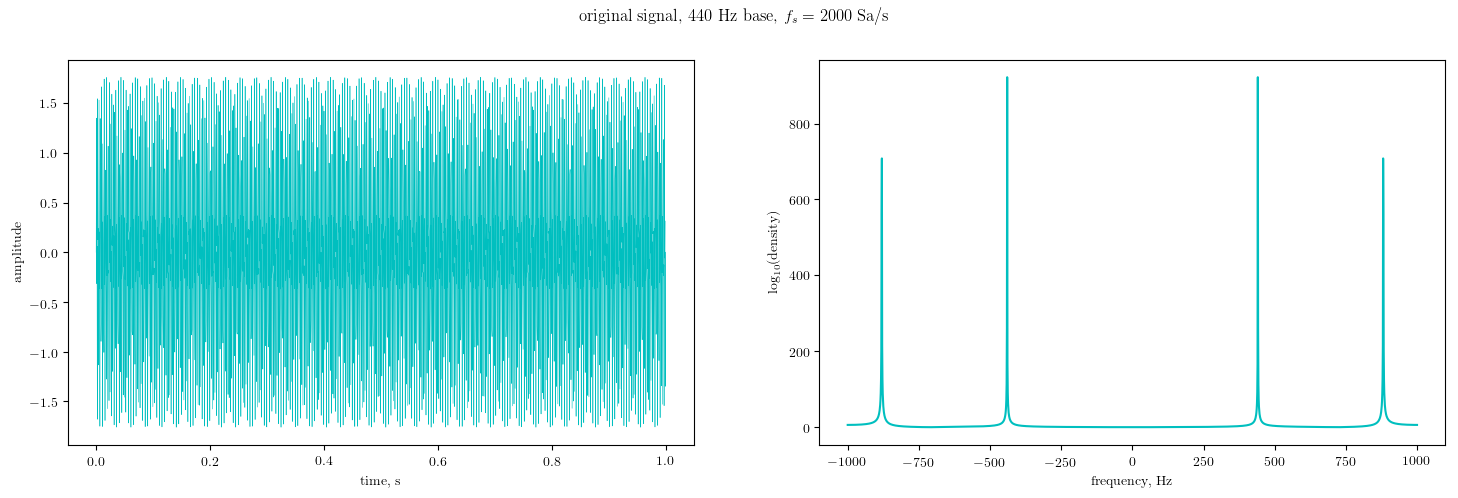

In [14]:
fig = mp.figure(figsize=(5*16/9*2, 5))

ax = fig.add_subplot(121)
ax.plot(t, sig, "c-", lw=0.4)
ax.set_xlabel("time, s")
ax.set_ylabel("amplitude")

fs = np.linspace(-rate/2, rate/2, N)
ax = fig.add_subplot(122)
ax.plot(fs, abs(cshift), "c-")
ax.set_xlabel("frequency, Hz")
ax.set_ylabel("$\log_{10}$(density)")

mp.suptitle("original signal, %i Hz base, $f_s = %i$ Sa/s"%(get_frequency(c, rate), rate))

# mp.savefig("sig_original.png", dpi=300, bbox_inches="tight", transparent=True)
mp.show()

disp.Audio(sig, rate=rate)

In [16]:
subrate = int(f2*1.5)
M = int(dur*subrate)
m = np.round(np.linspace(0, N-1, M)).astype(int)
y = sig[m]
tm = t[m]
beta = fft.fft(y)
betashift = fft.fftshift(abs(beta))

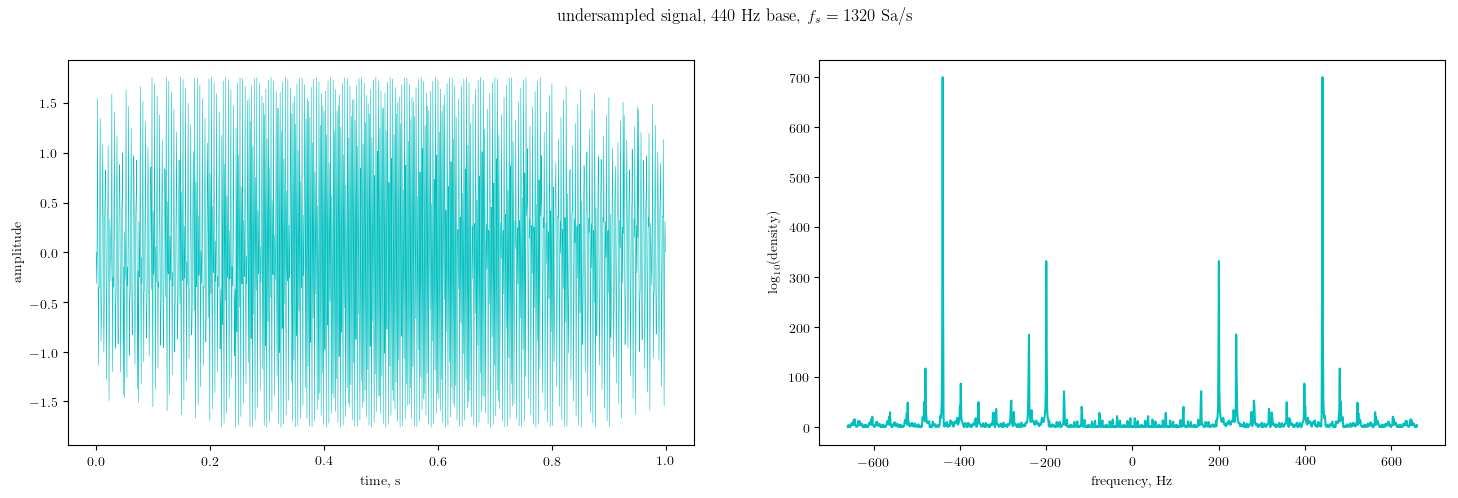

In [15]:
fig = mp.figure(figsize=(5*16/9*2, 5))

ax = fig.add_subplot(121)
ax.plot(tm, y, "c-", lw=0.4)
ax.set_xlabel("time, s")
ax.set_ylabel("amplitude")

fm = np.linspace(-subrate/2, subrate/2, M)
ax = fig.add_subplot(122)
ax.plot(fm, abs(betashift), "c-")
ax.set_xlabel("frequency, Hz")
ax.set_ylabel("$\log_{10}$(density)")

mp.suptitle("undersampled signal, %i Hz base, $f_s = %i$ Sa/s"%(get_frequency(beta, subrate), subrate))

# mp.savefig("sig_under.png", dpi=300, bbox_inches="tight", transparent=True)
mp.show()

disp.Audio(y, rate=subrate)

In [11]:
d = fft.dct(np.identity(N))
A = d[m]

In [12]:
prob = skl.Lasso(alpha=0.1)
prob.fit(A, y)
xhat = fft.idct(prob.coef_)
alphashift = abs(fft.fftshift(prob.coef_))

In [13]:
gamma = SL0(A, y)
gammashift = abs(fft.fftshift(gamma))
yhat = fft.idct(gamma)

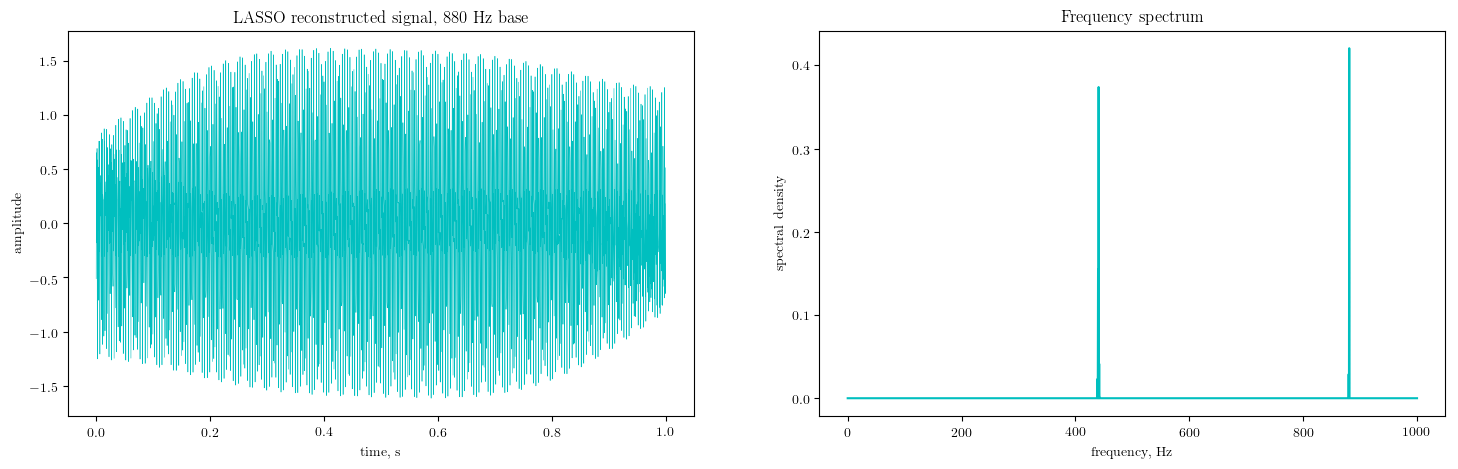

MSE = 0.064


In [17]:
fig = mp.figure(figsize=(5*16/9*2, 5))

ax = fig.add_subplot(121)
ax.plot(t, xhat, "c-", lw=0.4)
ax.set_xlabel("time, s")
ax.set_ylabel("amplitude")
ax.set_title("LASSO reconstructed signal, %i Hz base"%(get_frequency(prob.coef_, rate//2)))

fsl = np.linspace(0, rate//2, len(xhat))
ax = fig.add_subplot(122)
ax.plot(fsl, abs(prob.coef_), "c-")
ax.set_xlabel("frequency, Hz")
ax.set_ylabel("spectral density")
ax.set_title("Frequency spectrum")

mp.savefig("recon_lasso.png", dpi=300, bbox_inches="tight", transparent=True)
mp.show()

print("MSE = %.3f"%mse(sig, xhat))
disp.Audio(xhat, rate=rate)

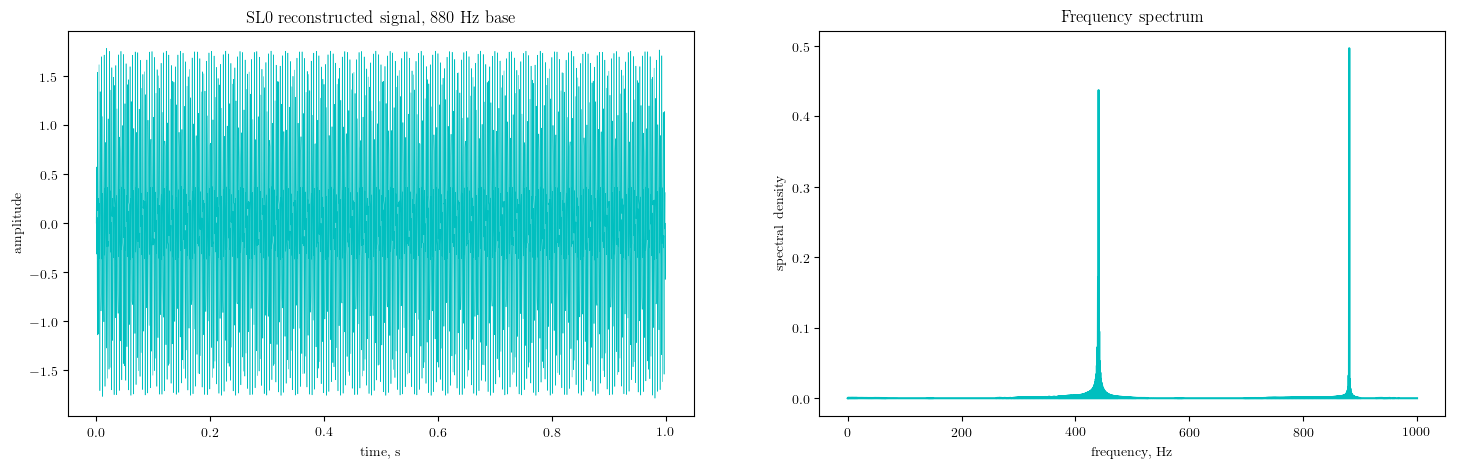

MSE = 0.001


In [18]:
fig = mp.figure(figsize=(5*16/9*2, 5))

ax = fig.add_subplot(121)
ax.plot(t, yhat, "c-", lw=0.4)
ax.set_xlabel("time, s")
ax.set_ylabel("amplitude")
ax.set_title("SL0 reconstructed signal, %i Hz base"%(get_frequency(gamma, rate//2)))

fsl = np.linspace(0, rate//2, len(yhat))
ax = fig.add_subplot(122)
ax.plot(fsl, abs(gamma), "c-")
ax.set_xlabel("frequency, Hz")
ax.set_ylabel("spectral density")
ax.set_title("Frequency spectrum")

mp.savefig("recon_sl0.png", dpi=300, bbox_inches="tight", transparent=True)
mp.show()

print("MSE = %.3f"%mse(sig, yhat))
disp.Audio(yhat, rate=rate)

# Real signal

In [19]:
rate, data = wav.read("guitar-midA.wav")
data = data.mean(axis=1)
No = len(data)
dur = No/rate
t = np.linspace(0, dur, No)
c = fft.fft(data)
cshift = fft.fftshift(c)

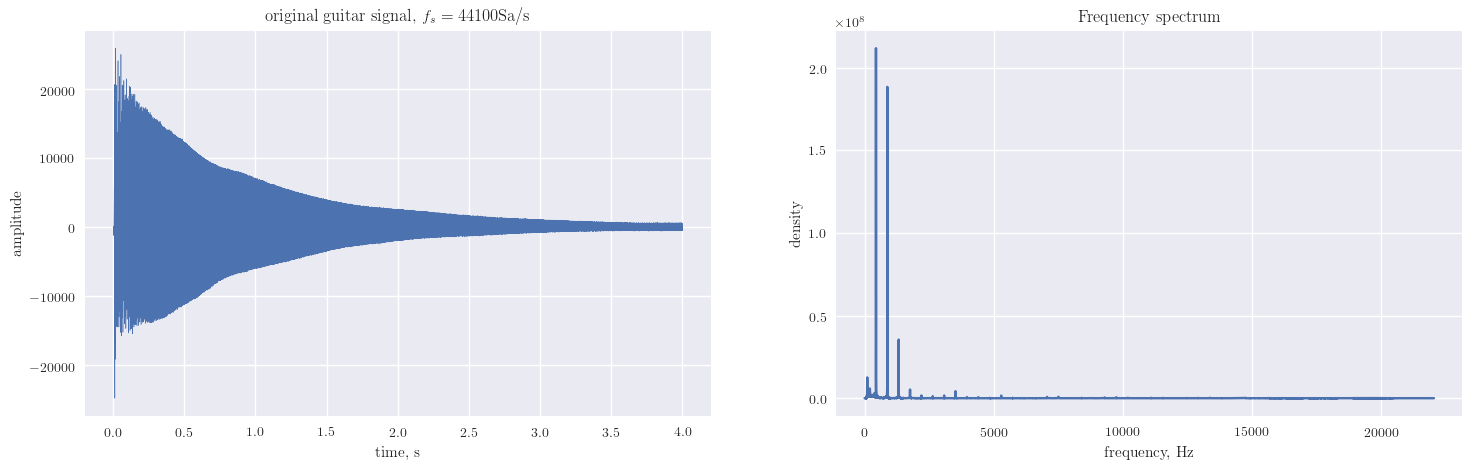

In [22]:
fig = mp.figure(figsize=(5*16/9*2, 5))

ax = fig.add_subplot(121)
ax.plot(t, data, lw=0.4)
ax.set_xlabel("time, s")
ax.set_ylabel("amplitude")
ax.set_title("original guitar signal, $f_s = %i$Sa/s"%(rate))

f = np.linspace(0, rate/2, No//2)
ax = fig.add_subplot(122)
ax.plot(f, abs(c)[:No//2])
ax.set_xlabel("frequency, Hz")
ax.set_ylabel("density")
ax.set_title("Frequency spectrum")

mp.savefig("guitar_orig.png", dpi=300, bbox_inches="tight")
mp.show()

disp.Audio(data, rate=rate)

In [23]:
downrate = 4000
N = int(downrate*dur)
n = np.round(np.linspace(0, No-1, N)).astype(int)
sig = data[n]
tn = np.linspace(0, dur, N)
c = fft.fft(sig)
cshift = fft.fftshift(c)

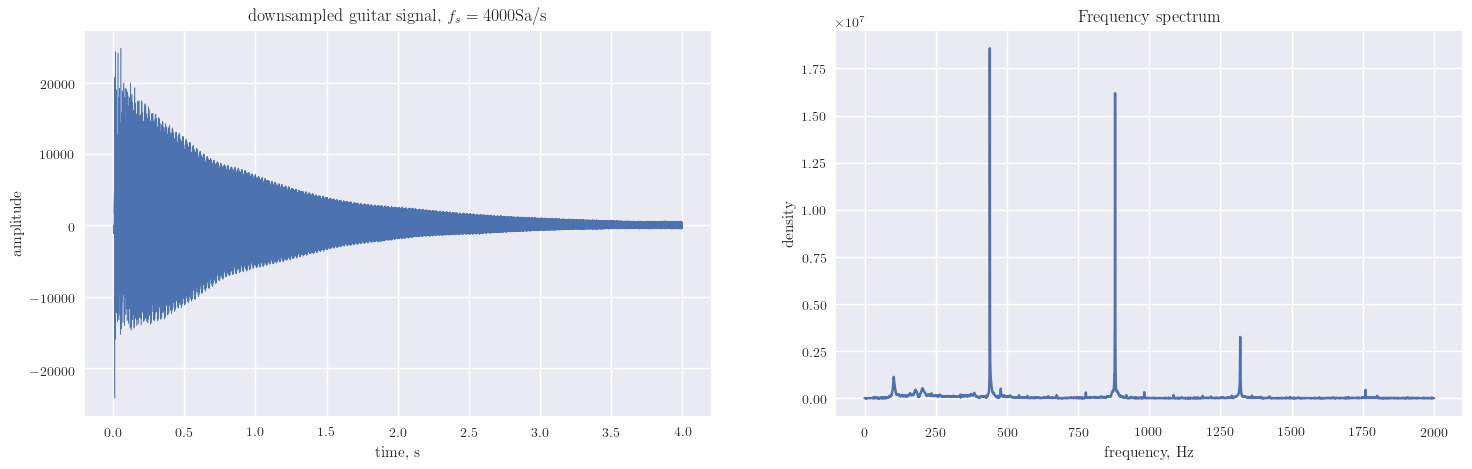

In [24]:
fig = mp.figure(figsize=(5*16/9*2, 5))

ax = fig.add_subplot(121)
ax.plot(tn, sig, lw=0.4)
ax.set_xlabel("time, s")
ax.set_ylabel("amplitude")
ax.set_title("downsampled guitar signal, $f_s = %i$Sa/s"%(downrate))

f = np.linspace(0, downrate/2, N//2)
ax = fig.add_subplot(122)
ax.plot(f, abs(c)[:N//2])
ax.set_xlabel("frequency, Hz")
ax.set_ylabel("density")
ax.set_title("Frequency spectrum")

mp.savefig("guitar_down.png", dpi=300, bbox_inches="tight")
mp.show()

disp.Audio(sig, rate=downrate)

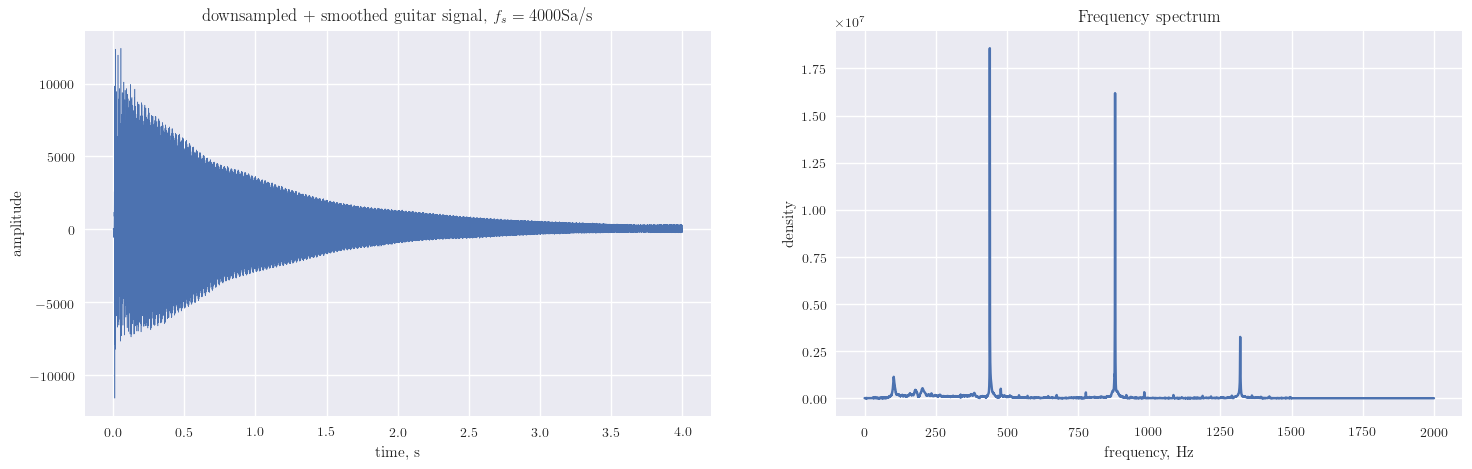

In [25]:
c[6000:] = 0
sig = fft.ifft(c).real

fig = mp.figure(figsize=(5*16/9*2, 5))

ax = fig.add_subplot(121)
ax.plot(tn, sig, lw=0.4)
ax.set_xlabel("time, s")
ax.set_ylabel("amplitude")
ax.set_title("downsampled + smoothed guitar signal, $f_s = %i$Sa/s"%(downrate))

f = np.linspace(0, downrate/2, N//2)
ax = fig.add_subplot(122)
ax.plot(f, abs(c)[:N//2])
ax.set_xlabel("frequency, Hz")
ax.set_ylabel("density")
ax.set_title("Frequency spectrum")

mp.savefig("guitar_downsmooth.png", dpi=300, bbox_inches="tight")
mp.show()

disp.Audio(sig, rate=downrate)

## Sub-Nyquist sampling

In [53]:
subrate = 2500
M = int(subrate*dur)
m = np.round(np.linspace(0, N-1, M)).astype(int)
y = sig[m]
tm = np.linspace(0, dur, M)
c = fft.fft(y)
cshift = fft.fftshift(c)

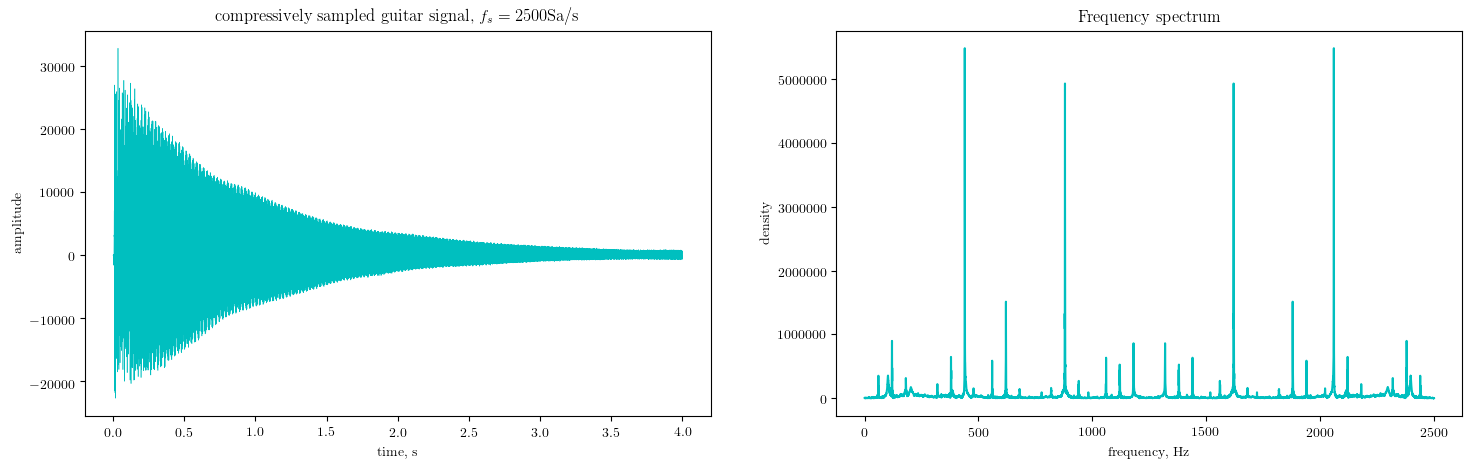

In [55]:
y = np.round(y/abs(y).max() * ((2**16 - 1)//2)).astype("int16")

fig = mp.figure(figsize=(5*16/9*2, 5))

ax = fig.add_subplot(121)
ax.plot(tm, y, "c-", lw=0.4)
ax.set_xlabel("time, s")
ax.set_ylabel("amplitude")
ax.set_title("compressively sampled guitar signal, $f_s = %i$Sa/s"%(subrate))

f = np.linspace(0, subrate, M)
ax = fig.add_subplot(122)
ax.plot(f, abs(c), "c-")
ax.set_xlabel("frequency, Hz")
ax.set_ylabel("density")
ax.set_title("Frequency spectrum")

mp.savefig("guitar_subnyq_comp.png", dpi=300, bbox_inches="tight", transparent=True)
mp.show()

wav.write("guitar-midA_subnyqcomp.wav", subrate, y)

disp.Audio(y, rate=subrate)

In [56]:
d = fft.dct(np.identity(N))
A = d[m]

In [57]:
#prob = skl.OrthogonalMatchingPursuit(n_nonzero_coefs=20)
prob = skl.Lasso(alpha=1.0)
prob.fit(A, y)
beta = prob.coef_
bshift = fft.fftshift(beta)
xhat = fft.idct(beta)

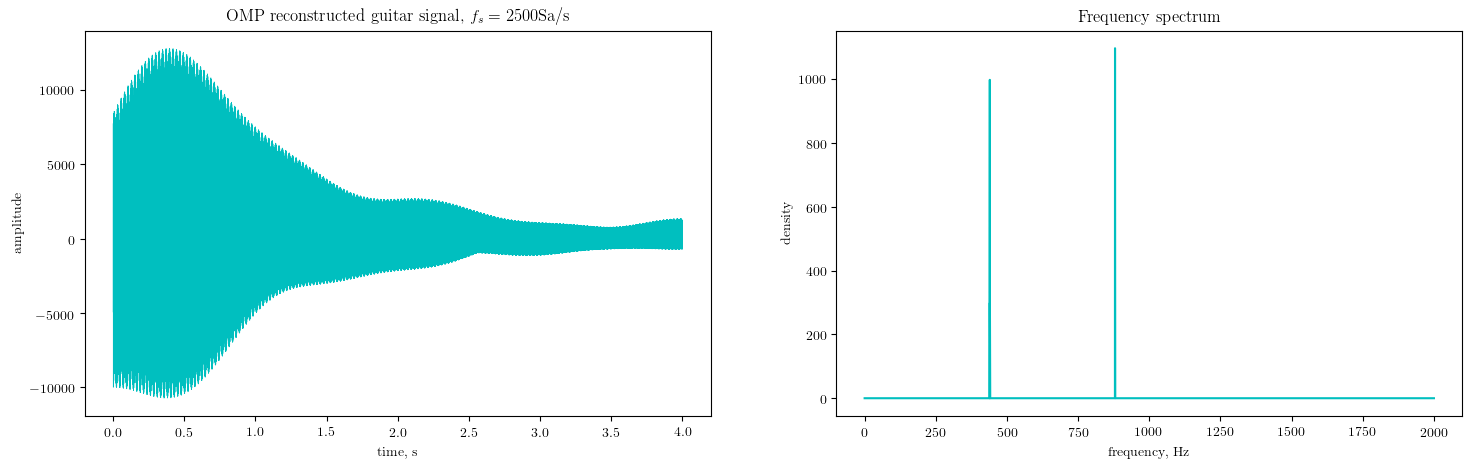

MSE = 1704331.499


In [17]:
xhat = fft.idct(beta)

fig = mp.figure(figsize=(5*16/9*2, 5))

ax = fig.add_subplot(121)
ax.plot(tn, xhat.real, "c-", lw=0.4)
ax.set_xlabel("time, s")
ax.set_ylabel("amplitude")
ax.set_title("OMP reconstructed guitar signal, $f_s = %i$Sa/s"%(subrate))

f = np.linspace(0, downrate/2, N)
ax = fig.add_subplot(122)
ax.plot(f, abs(beta), "c-")
ax.set_xlabel("frequency, Hz")
ax.set_ylabel("density")
ax.set_title("Frequency spectrum")

mp.savefig("guitar_recon_omp.png", dpi=300, bbox_inches="tight", transparent=True)
mp.show()

print("MSE = %.3f"%mse(sig, xhat.real))
disp.Audio(xhat, rate=downrate)

## Random sampling

In [26]:
subrate = 2500
M = int(subrate*dur)
m = np.sort(rd.randint(0, N, M))
y = sig[m]
tm = tn[m]
c = fft.fft(y)
cshift = fft.fftshift(c)

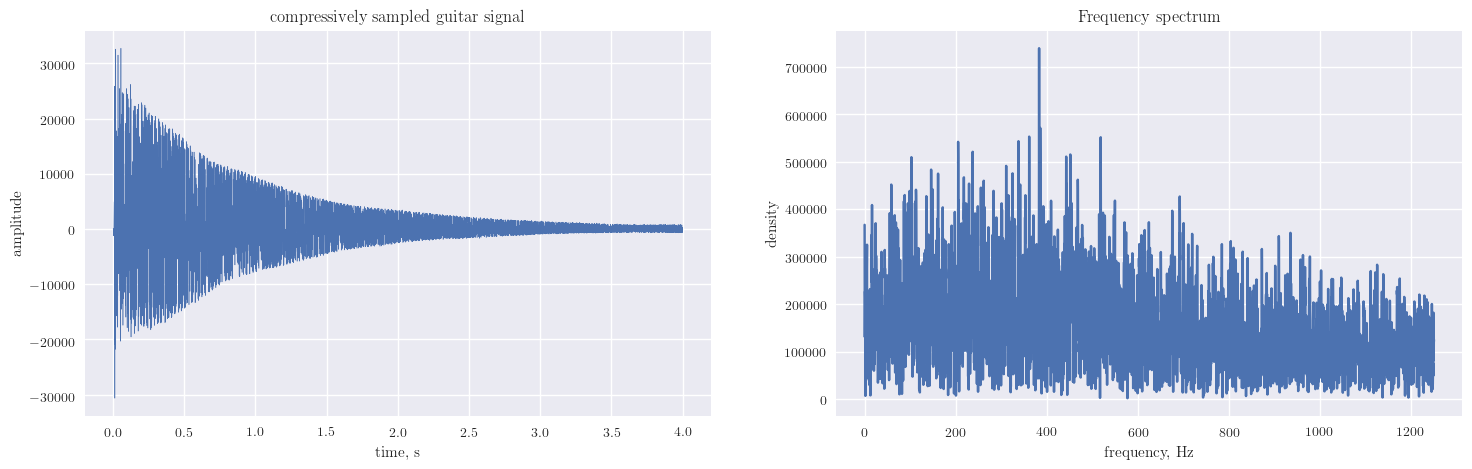

In [27]:
y = np.round(y/abs(y).max() * ((2**16-1)//2)).astype("int16")

fig = mp.figure(figsize=(5*16/9*2, 5))

ax = fig.add_subplot(121)
ax.plot(tm, y, lw=0.4)
ax.set_xlabel("time, s")
ax.set_ylabel("amplitude")
ax.set_title("compressively sampled guitar signal")

f = np.linspace(0, subrate/2, M//2)
ax = fig.add_subplot(122)
ax.plot(f, abs(c)[:M//2])
ax.set_xlabel("frequency, Hz")
ax.set_ylabel("density")
ax.set_title("Frequency spectrum")

mp.savefig("guitar_random_comp.png", dpi=300, bbox_inches="tight")
mp.show()

#wav.write("guitar-midA_compressed.wav", subrate, y)

disp.Audio(y, rate=subrate)

In [28]:
d = fft.dct(np.identity(N))
A = d[m]

In [29]:
prob = skl.Lasso(alpha=1.0)
prob.fit(A, y)
beta = prob.coef_
xhat_lasso = fft.idct(beta)

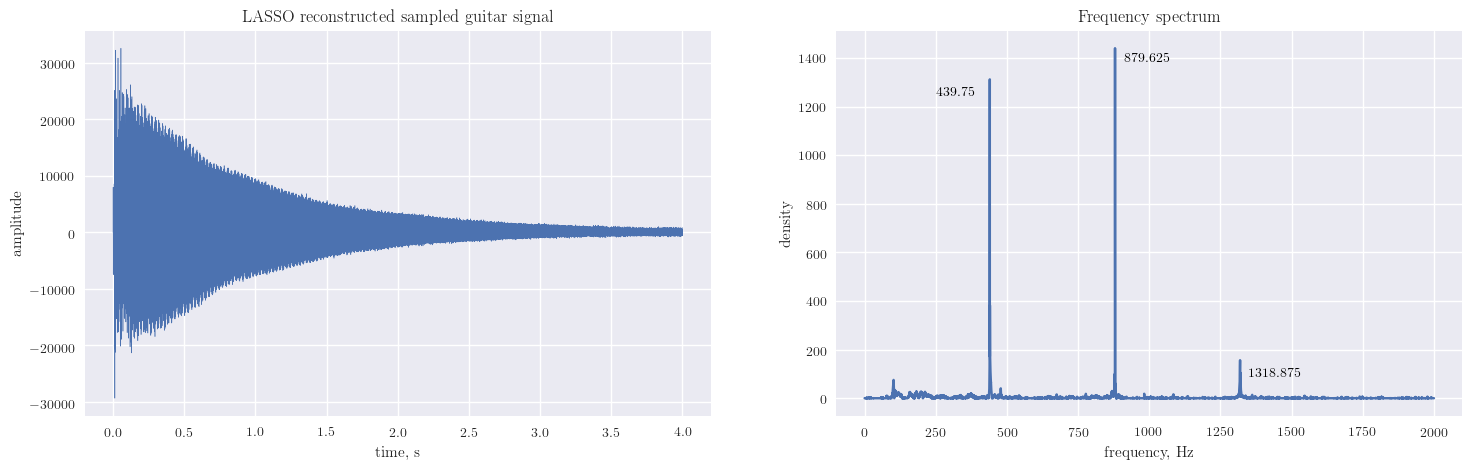

MSE = 8015831.739


In [31]:
#xhat = fft.idct(beta)
# xhat_lasso = np.round(xhat_lasso/xhat_lasso.max() * ((2**16 - 1)//2)).astype("int16")

fig = mp.figure(figsize=(5*16/9*2, 5))

ax = fig.add_subplot(121)
ax.plot(tn, xhat_lasso, lw=0.4)
ax.set_xlabel("time, s")
ax.set_ylabel("amplitude")
ax.set_title("LASSO reconstructed sampled guitar signal")

f = np.linspace(0, downrate/2, N)
ax = fig.add_subplot(122)
ax.plot(f, abs(beta))
ax.set_xlabel("frequency, Hz")
ax.set_ylabel("density")
ax.text(0.16, 0.83, (np.argmax(abs(beta)[2000:4000])+2000)/N*downrate/2, transform=ax.transAxes, color="k")
ax.text(0.46, 0.92, (np.argmax(abs(beta)[6000:8000])+6000)/N*downrate/2, transform=ax.transAxes, color="k")
ax.text(0.66, 0.10, (np.argmax(abs(beta)[10000:12000])+10000)/N*downrate/2, transform=ax.transAxes, color="k")
ax.set_title("Frequency spectrum")

mp.savefig("guitar_random_recon_lasso.png", dpi=300, bbox_inches="tight")
mp.show()

#wav.write("guitar-midA_recon_lasso.wav", downrate, xhat_lasso)

print("MSE = %.3f"%mse(sig, xhat_lasso.real))
disp.Audio(xhat_lasso.real, rate=downrate)

In [62]:
prob = skl.OrthogonalMatchingPursuit()
prob.fit(A, y)
gamma = prob.coef_
xhat_omp = fft.idct(gamma)

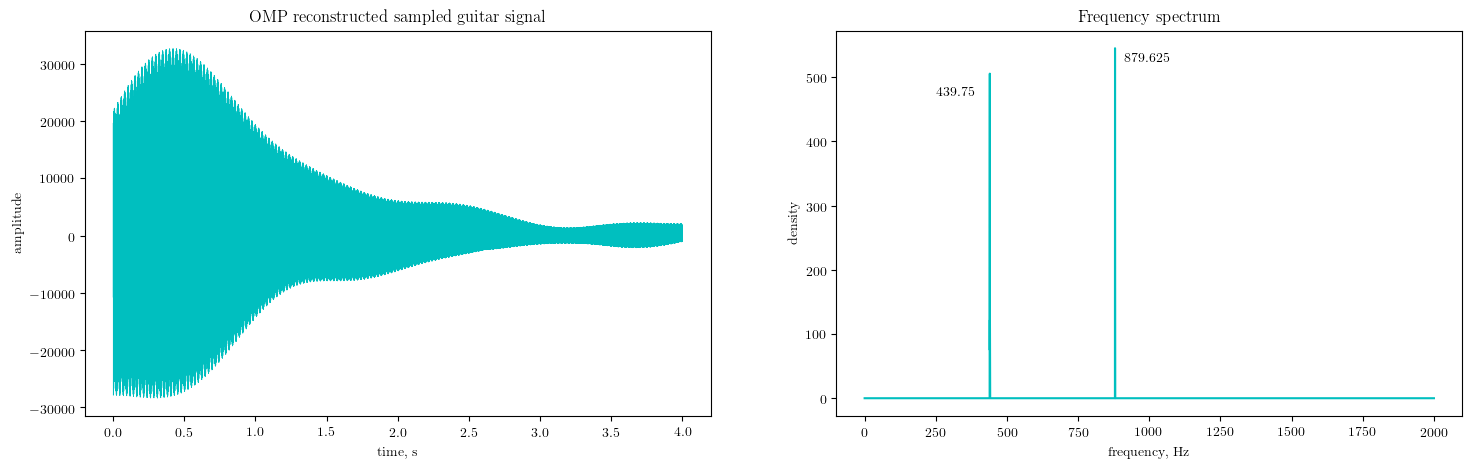

MSE = 47647874.351


In [64]:
xhat_omp = fft.idct(gamma)
xhat_omp = np.round(xhat_omp/abs(xhat_omp).max() * ((2**16 - 1)//2)).astype("int16")

fig = mp.figure(figsize=(5*16/9*2, 5))

ax = fig.add_subplot(121)
ax.plot(tn, xhat_omp, "c-", lw=0.4)
ax.set_xlabel("time, s")
ax.set_ylabel("amplitude")
ax.set_title("OMP reconstructed sampled guitar signal")

f = np.linspace(0, downrate//2, N)
ax = fig.add_subplot(122)
ax.plot(f, abs(gamma), "c-")
ax.set_xlabel("frequency, Hz")
ax.set_ylabel("density")
ax.text(0.16, 0.83, (np.argmax(abs(gamma)[2000:4000])+2000)/N*downrate/2, transform=ax.transAxes, color="k")
ax.text(0.46, 0.92, (np.argmax(abs(gamma)[6000:8000])+6000)/N*downrate/2, transform=ax.transAxes, color="k")
#ax.text(0.66, 0.10, (np.argmax(abs(beta)[10000:12000])+10000)/N*downrate/2, transform=ax.transAxes, color="w")
ax.set_title("Frequency spectrum")

mp.savefig("guitar_random_recon_omp.png", dpi=300, bbox_inches="tight", transparent=True)
mp.show()

wav.write("guitar-midA_recon_omp.wav", downrate, xhat_omp)

print("MSE = %.3f"%mse(sig, xhat_omp.real))
disp.Audio(xhat, rate=downrate)

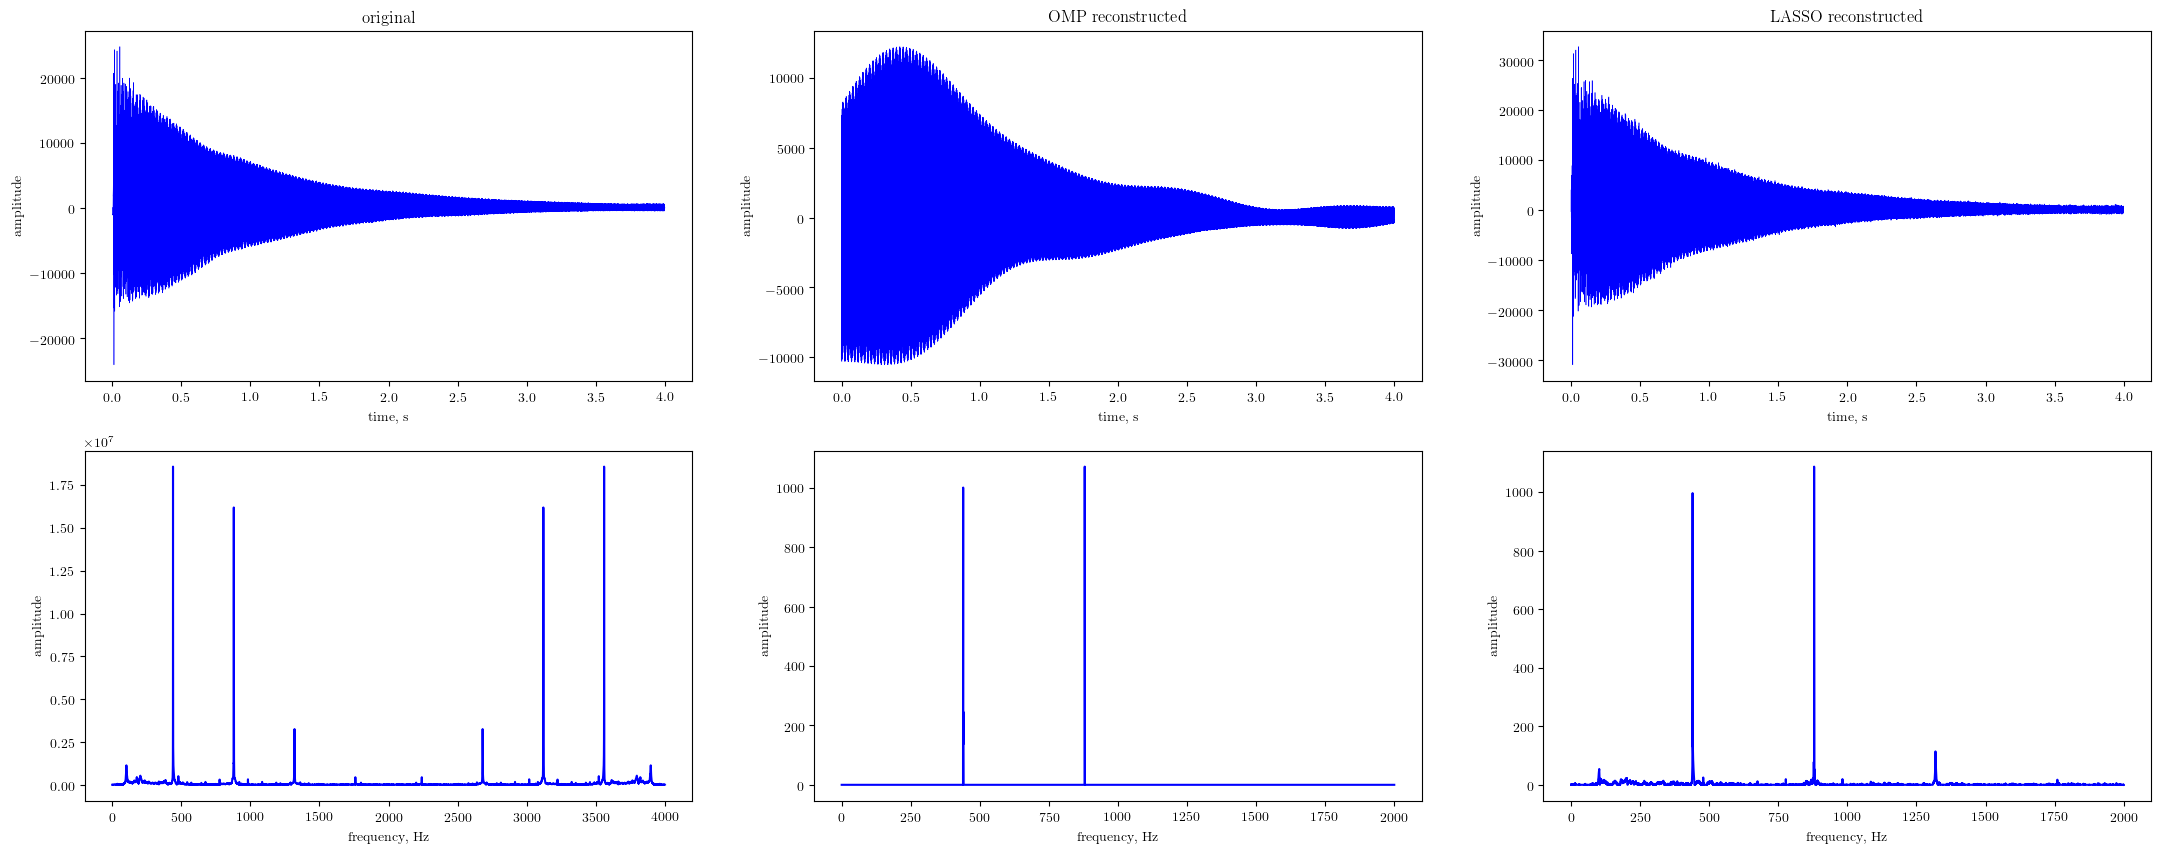

In [74]:
fig = mp.figure(figsize=(5*16/9*3, 5*2))

ax = fig.add_subplot(231)
ax.plot(tn, sig, "b-", lw=0.4)
ax.set_xlabel("time, s")
ax.set_ylabel("amplitude")
ax.set_title("original")

ax = fig.add_subplot(232)
ax.plot(tn, xhat_omp, "b-", lw=0.4)
ax.set_xlabel("time, s")
ax.set_ylabel("amplitude")
ax.set_title("OMP reconstructed")

ax = fig.add_subplot(233)
ax.plot(tn, xhat_lasso, "b-", lw=0.4)
ax.set_xlabel("time, s")
ax.set_ylabel("amplitude")
ax.set_title("LASSO reconstructed")

f = np.linspace(0, downrate, N)
ax = fig.add_subplot(234)
ax.plot(f, abs(c), "b-")
ax.set_xlabel("frequency, Hz")
ax.set_ylabel("amplitude")

f = np.linspace(0, downrate/2, N)
ax = fig.add_subplot(235)
ax.plot(f, abs(gamma), "b-")
ax.set_xlabel("frequency, Hz")
ax.set_ylabel("amplitude")

ax = fig.add_subplot(236)
ax.plot(f, abs(beta), "b-")
ax.set_xlabel("frequency, Hz")
ax.set_ylabel("amplitude")

mp.savefig("metho_compare.png", bbox_inches="tight", dpi=300, transparent=True)
mp.show()

In [26]:
kappa = SL0(A, y, sigma_min=1e-12)
xhat = fft.idct(kappa)

LinAlgError: SVD did not converge

In [3]:
xhat = fft.idct(kappa)

fig = mp.figure(figsize=(5*16/9*2, 5))

ax = fig.add_subplot(121)
ax.plot(tn, xhat, "c-", lw=0.4)
ax.set_xlabel("time, s")
ax.set_ylabel("amplitude")

f = np.linspace(0, downrate/2, N)
ax = fig.add_subplot(122)
ax.plot(f, abs(kappa), "c-")
ax.set_xlabel("frequency, Hz")
ax.set_ylabel("density")
ax.text(0.16, 0.83, (np.argmax(abs(kappa)[2000:4000])+2000)/N*downrate/2, transform=ax.transAxes, color="k")
ax.text(0.46, 0.92, (np.argmax(abs(kappa)[6000:8000])+6000)/N*downrate/2, transform=ax.transAxes, color="k")
ax.text(0.66, 0.10, (np.argmax(abs(kappa)[10000:12000])+10000)/N*downrate/2, transform=ax.transAxes, color="k")

mp.suptitle("SL0 reconstructed sampled guitar signal")

mp.savefig("guitar_random_recon_sl0.png", dpi=300, bbox_inches="tight", transparent=True)
mp.show()

print("MSE = %.3f"%mse(sig, xhat.real))
disp.Audio(xhat, rate=downrate)

NameError: name 'kappa' is not defined